# Anime faces starting kit

_MAI Huu Tan, CARON Marceau, SALOMON Yohann, LIU Annie, BERTHOLOM François & BIGOT Alexandre_

# Table of content


## Introduction

The task of this challenge is to build a generative model that can create realistic images of anime faces, given a set of training data. Generative models are a class of machine learning models that aim to learn the underlying probability distribution of the data, allowing them to generate new samples that are similar to the training data.

The ability to generate new, high-quality data has numerous applications in various fields, including art, entertainment, and gaming. In particular, the task of generating anime faces has become increasingly popular in the anime and manga communities, where the demand for high-quality illustrations is ever increasing.

Generative modeling has gained considerable attention in recent years due to rapid and spectacular advances, with a lot of new practical techniques. The state of the art in image generation is currently achieved with diffusion or score-based models, which are quite expensive in terms of computational resources, requiring both long training and inference times. In this challenge, the aim is to build, train and fine-tune generative models that can generate high-quality and diverse samples with an input of small dimension compared to that of the generated images.

Various approaches have been developped to tackle this problem, including generative adversarial networks (GANs), variational autoencoders (VAEs), and flow-based models.

![ganyu](\img\103118764_p3_master1200_.jpg)

In particular, some Stable Diffusions became very popular for generating anime artwork. For example, NovelAI became very popular for being able to generate high quality anime illustrations from text. The above image, for instance, is an image of Ganyu, a character from the well-known game Genshin Impact, generated from text by NovelAI.

This challenge provides an opportunity to explore these different techniques and push the limits of generative modeling for anime face generation, in a more simplistic setting. The competitor is asked to generate a colored $64 \times 64$ image that shows the face of an anime character.

The provided dataset is an adapted version of [Brian Chao's Anime Face Dataset](https://github.com/bchao1/Anime-Face-Dataset). The public data consists of roughly 30 000 images in jpg format, split into three training sets of roughly 10 000 images each. The images have been centered and cropped, thus all have a size of $64 \times 64$. The private dataset contains roughly 30 000 images.

Since those datasets have no image in common, the challenge will test the robustness of the competitor's model, as well as its ability to adapt to each of the training sets.

In [12]:
# % matplotlib inline
import os
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, Normalize, RandomHorizontalFlip
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
import torchvision.utils as vutils

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

seed = 0
torch.manual_seed(seed)
print(f'Torch random seed: {seed}.')

Torch random seed: 0.


## Getting started with the RAMP starting kit
### Software prerequisites
This starting kit requires the following dependancies:
* ```torch```
* ```numpy```
* ```ramp-workflow```

However, to build and deploy your generative model, you may use any deep learning library you are comfortable with (```tensorflow```, ```jax```, etc.).

To install the dependancies (including ```torch```) using ```pip``` you may run:

In [4]:
# !pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'



### Getting the data
The public train and test data can be downloaded by running from the root of the starting kit:

In [1]:
# !python download_data.py

## The data

### Datasets and loaders with ```torch```

To exemplify the creation and usage of datasets and dataloaders using ```torch```, we are going to load data from the first public training set.

In [13]:
__file__ = "./anime_faces_starting_kit.ipynb"
PATH = Path(__file__).parent / "data"

paths = []
for p in PATH.rglob("*.jpg"):
    paths.append(p)

In [14]:
print(paths[:5])

[WindowsPath('data/train_1/10001.jpg'), WindowsPath('data/train_1/10007.jpg'), WindowsPath('data/train_1/10011.jpg'), WindowsPath('data/train_1/10015.jpg'), WindowsPath('data/train_1/10018.jpg')]


Image id: 10011.jpg
Image size: (64, 64)


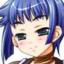

In [15]:
example = Image.open(paths[2])
print(f'Image id: {paths[2].name}')
print(f'Image size: {example.size}')
example

When loading images to ```Python``` using the ```pillow``` library, they come in a format that is not suitable to work on a deep learning task. 

In [16]:
type(example)

PIL.JpegImagePlugin.JpegImageFile

```torch.transforms``` has a variety of methods to work with images and make a transition between ```pillow``` and ```torch```. 

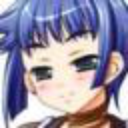

In [29]:
Resize(128)(example)

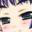

In [17]:
CenterCrop(32)(example)

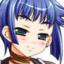

In [18]:
RandomHorizontalFlip(1)(example)

In [19]:
example_ten = ToTensor()(example)
example_ten.size()

torch.Size([3, 64, 64])

It is often more convenient to have a series of transforms that we apply to every image we are going to use for the training phase.

In [20]:
image_size = 64
channels = 3

training_transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

example_ten = training_transform(example)
example_ten.size()

torch.Size([3, 64, 64])

To apply this transform to every image we want to load in order to train the model, we define a subclass of the ```torch.utils.data.Dataset``` class.

In [21]:
class ImageSet(Dataset):
    """This class inherits from the Dataset class of PyTorch and is used to load the images locally with the paths of the images.

    The images are already transformed beforehand, so all there is to do in order to feed them to the metrics is to send them in
    minibatches using a DataLoader object.
    """

    def __init__(self, paths, transform, preload=False):
        """Initializes the dataset from a tuple of paths.

        Args:
            paths (tuple of `str` objects): tuple of strings containing the paths of the images used in the Dataset.
            transform (Compose): A composition of transforms to be applied on the images.
            preload (bool, optional): A boolean to indicate whether the images are preloaded as PyTorch Tensor objects. Defaults to False.
        """
        self.paths = paths
        self.transform = transform
        self.preload = preload
        if self.preload:
            self.files = [
                self.transform(
                    Image.open(path)
                ) for path in self.paths]

    def __getitem__(self, index):
        """Gets an item from the dataset.

        Args:
            index (int): The index of the image in the dataset.

        Returns:
            Tensor: the `index`-th image in the dataset.
        """
        if self.preload:
            return self.files[index]
        else:
            return self.transform(
                Image.open(self.paths[index])
            )

    def __len__(self):
        """Returns the number of images in the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.paths)

We can now set the batch size we want for our dataloader.
Batch size is tricky to tune: a larger batch size usually means faster epochs (but with less steps per epoch) and better gradient approximation, but it is also costlier in terms of memory. The largest batch size supported by your hardware is going to be the best solution in most cases.

In [22]:
# Consider changing the batch_size to suit your hardware.
batch_size = 128

training_set = ImageSet(
    paths=paths,
    transform=training_transform,
    preload=True,
)

training_loader = DataLoader(
    training_set,
    batch_size=batch_size,
    shuffle=True
)

We can plot some examples...

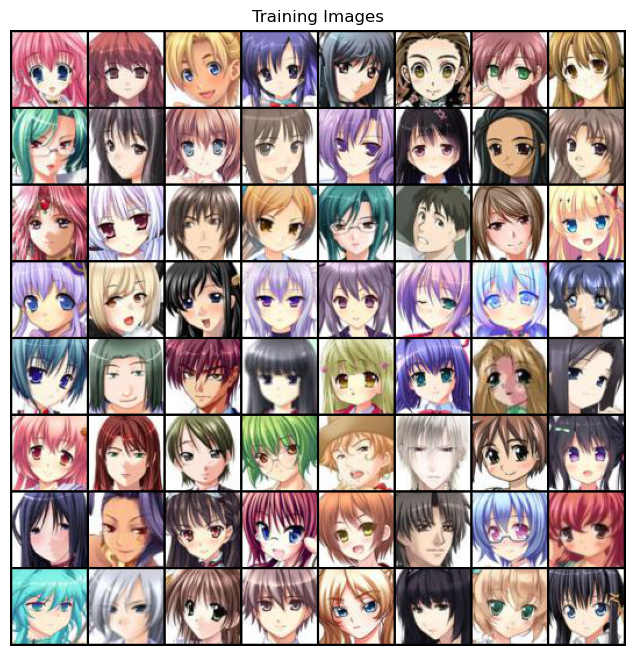

In [23]:
batch = next(iter(training_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

## Buiding a generative model using ```torch```

### Variational Auto-Encoder (VAE)



[Variational Auto-Encoders](https://arxiv.org/abs/1312.6114) (VAEs) were introduced in 2014 by Kingma and Welling. They learn to sample from the target distribution by encoding input data into a lower-dimensional latent space and decoding the latent representation back into the original data.

During training, a VAE learns to map the input data to a given distribution in the latent space, and to reconstruct the original image from the latent representation. Inference is simply done by sampling from the latent distribution and decoding this input.

The key idea behind VAEs is to regularize the latent space to encourage it to follow a specific distribution, typically a multivariate Gaussian distribution. This is achieved by adding a regularization term to the loss function that penalizes the deviation of the learned distribution from the target distribution. The regularization term is defined using the Kullback-Leibler (KL) divergence between the learned distribution and the target distribution.

You will find a formal exaplanation of the VAE in appendix.

In [61]:
def vae_loss(x, x_hat, mu, log_var, beta=1.0):
    recon_loss = nn.BCELoss(reduction='sum')(x_hat, x)
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kld_loss

Let us define the model. It consists of two modules - the encoder and the decoder.

In [66]:
class VAE(nn.Module):
    def __init__(self, channels, features, latent_dim):
        super(VAE, self).__init__()
        self.channels = channels
        self.features = features
        self.latent_dim = latent_dim

        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Define mean and variance layers for latent variable
        self.fc_mu = nn.Linear(in_features=256 * (features // 8) ** 2, out_features=latent_dim)
        self.fc_var = nn.Linear(in_features=256 * (features // 8) ** 2, out_features=latent_dim)

        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=256 * (features // 8) ** 2),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(256, features // 8, features // 8)),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var

We need to set the model's hyperparameters (model size), as well as the training hyperparameters.

In [67]:
# Model hyperparameters
latent_dim = 50
features = 64

# Instantiate the model
vae = VAE(channels, features, latent_dim)
print(vae)

# Training hyperparameters
epochs = 25
learning_rate = 5e-5
betas = (0.9, 0.999)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate, betas=betas)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=16384, out_features=50, bias=True)
  (fc_var): Linear(in_features=16384, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=16384, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 8, 8))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 

To avoid being stuck in the training phase for months, we need to use GPUs.

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"

vae.to(device)

print(device)

cuda


In [72]:
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch} of {epochs}.")
    total_loss = 0
    for x in tqdm(training_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, log_var = vae(x)
        loss = vae_loss(x, x_hat, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Mean loss over the last epoch: {total_loss / len(training_loader.dataset):.4f}")
    print()

Epoch 1 of 25.


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:08<00:00, 10.22it/s]


Mean loss over the last epoch: -84618.3361

Epoch 2 of 25.


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:08<00:00, 10.21it/s]


Mean loss over the last epoch: -88672.4849

Epoch 3 of 25.


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:08<00:00, 10.21it/s]


Mean loss over the last epoch: -92119.0902

Epoch 4 of 25.


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:08<00:00, 10.21it/s]


Mean loss over the last epoch: -94911.0770

Epoch 5 of 25.


 37%|██████████████████████████████▋                                                   | 31/83 [00:03<00:05,  9.87it/s]


KeyboardInterrupt: 

Once the training is completed, we can run the inference and display the generated images.

In [ ]:
batch_size = 64

with torch.no_grad():
    random_noise = torch.randn(batch_size, latent_dim, device=device)
    batch = model.decoder(random_noise)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(), (1, 2, 0)))

To save the model's weights, use the following command:

In [ ]:
try:
    os.mkdir(f"./example_models/")
except FileExistsError:
    pass

torch.save(vae.state_dict(), f"./example_models/vae_{steps}.pth")

To load it back, use ```load_state_dict()```:

In [ ]:
del (vae)

vae = VAE(channels, features, latent_dim).to(device)
vae.load_state_dict(torch.load(f"./example_models/vae_{steps}.pth"))

### Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are a type of generative model that involves training two networks: a generator and a discriminator. The generator is trained to produce realistic samples from the target distribution and the discriminator to correctly distinguish between real and generated samples.

During training, the generator takes random noise as input and generates a sample, which is then fed into the discriminator along with real samples from the training data. The discriminator network learns to correctly classify the samples as real or fake, while the generator network learns to generate samples that fool the discriminator into thinking they are real. This process can be thought of as a game between the generator and discriminator. The game is considered to be a zero-sum game, as the loss of one network is equal to the gain of the other network.

In [73]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, channels, latent, features):
        super(Generator, self).__init__()
        self.body = nn.Sequential(
            nn.ConvTranspose2d(latent, features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 8, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 4, features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 2, features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(True),

            nn.ConvTranspose2d(features, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.body(x)


class Discriminator(nn.Module):
    def __init__(self, channels, features):
        super(Discriminator, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 4, features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.body(x)

Once again, we need to choose the dimensions of our model and the training parameters. This time we have two optimizers, since we need to train two neural networks.

In [78]:
# Models dimensions
latent_size = 100
features_g = 64
features_d = 64

# Instantiate the models and initialize the weights
generator = Generator(channels, latent_size, features_g).to(device)
generator.apply(weights_init)
print(generator)

discriminator = Discriminator(channels, features_d).to(device)
discriminator.apply(weights_init)
print(discriminator)

# Training hyperparameters
epochs = 25
lr_g = 2e-4
lr_d = 2e-4
beta1 = 0.5

optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, 0.999))

Generator(
  (body): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


We also need to set a convention for the discriminator to distinguish between real and fake samples.

In [80]:
criterion = nn.BCELoss()

# convention
real_label = 1.
fake_label = 0.

We can now start training.

In [82]:
g_losses = []
d_losses = []
results = {
    "d_real_score": [],
    "d_fake_score": [],
    "d_fake_score_2": [],
    "loss_d": [0.],
    "loss_g": [0.],
}
steps = 0

In [83]:
generator.train()
discriminator.train()

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch} of {epochs}.")
    print(f'Last epoch mean discriminator loss: {results["loss_d"][-1]}.')
    print(f'Last epoch mean generator loss: {results["loss_g"][-1]}.')
    running = {
        "d_real_score": 0.,
        "d_fake_score": 0.,
        "d_fake_score_2": 0.,
        "loss_d": 0.,
        "loss_g": 0.,
    }
    for batch in tqdm(training_loader):
        # (1) update the discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        # all-real batch
        discriminator.zero_grad()
        real_img = batch.to(device)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        real_out = discriminator(real_img).view(-1)
        loss_real = criterion(real_out, label)
        loss_real.backward()

        # all-fake batch
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        fake_out = discriminator(fake.detach()).view(-1)
        loss_fake = criterion(fake_out, label)
        loss_fake.backward()

        optimizer_d.step()

        d_real_score = real_out.mean().item()
        d_fake_score = fake_out.mean().item()
        loss_d = loss_real + loss_fake

        # (2) update the generator: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        fake_out = discriminator(fake).view(-1)
        loss_g = criterion(fake_out, label)
        loss_g.backward()
        optimizer_g.step()

        d_fake_score_2 = fake_out.mean().item()
        steps += 1

        running["d_real_score"] += d_real_score
        running["d_fake_score"] += d_fake_score
        running["loss_d"] += loss_d.item()
        running["d_fake_score_2"] += d_fake_score_2
        running["loss_g"] += loss_g.item()

        # for plots
        g_losses.append(loss_d.item())
        d_losses.append(loss_g.item())

    results["d_real_score"].append(running["d_real_score"] / len(training_loader))
    results["d_fake_score"].append(running["d_fake_score"] / len(training_loader))
    results["loss_d"].append(running["loss_d"] / len(training_loader))
    results["d_fake_score_2"].append(running["d_fake_score_2"] / len(training_loader))
    results["loss_g"].append(running["loss_g"] / len(training_loader))

    # Make checkpoints
    if epoch % 5 == 0:
        torch.save(generator.state_dict(), f"./models/generator_{steps}.pth")
        torch.save(discriminator.state_dict(), f"./models/discriminator_{steps}.pth")

Epoch 1 of 25.
Last epoch mean discriminator loss: 0.0.
Last epoch mean generator loss: 0.0.


 27%|█████████████████████▋                                                            | 22/83 [00:05<00:14,  4.07it/s]


KeyboardInterrupt: 

Plot the training results to make sure everything went smoothly.

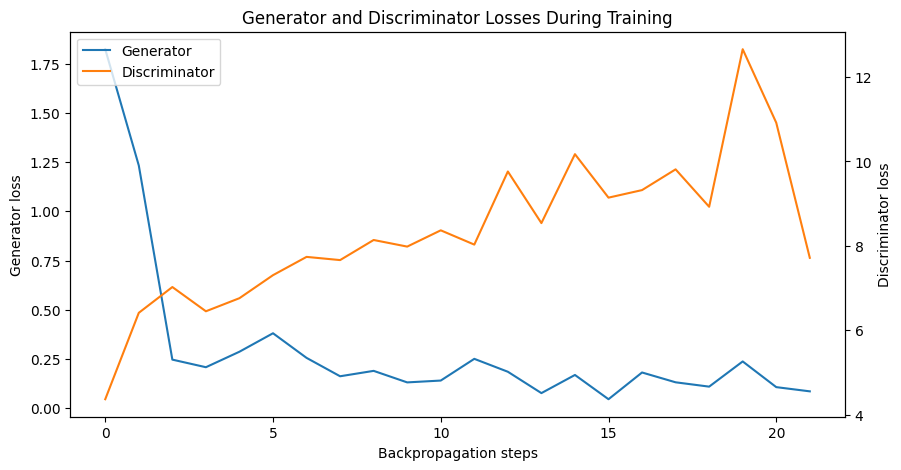

In [104]:
fig = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Losses During Training")
ax1 = plt.subplot()
l1, = ax1.plot(g_losses, color="tab:blue")
ax2 = ax1.twinx()
l2, = ax2.plot(d_losses, color="tab:orange")
ax1.set_xlabel("Backpropagation steps")
ax1.set_ylabel("Generator loss")
ax2.set_ylabel("Discriminator loss")
plt.legend([l1, l2], ["Generator", "Discriminator"])
plt.show()

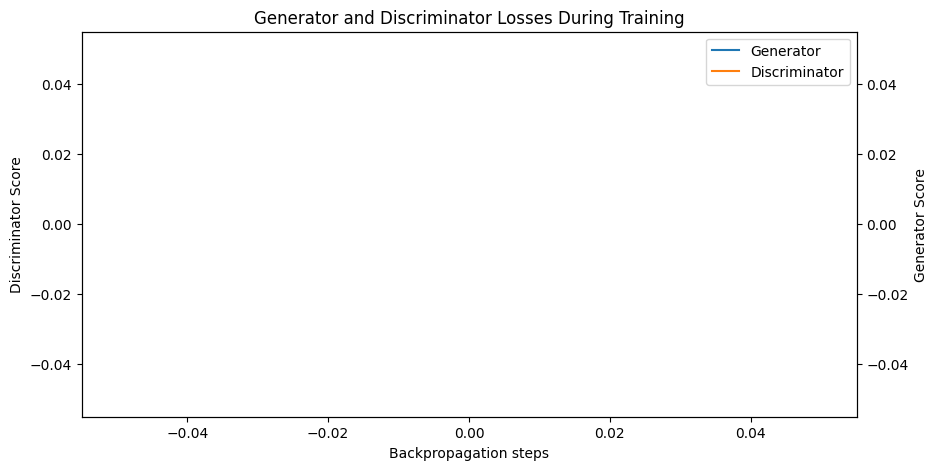

In [105]:
fig = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Losses During Training")
ax1 = plt.subplot()
l1, = ax1.plot(results["d_real_score"], color="tab:blue")
ax2 = ax1.twinx()
l2, = ax2.plot(results["d_fake_score"], color="tab:orange")
ax1.set_xlabel("Backpropagation steps")
ax1.set_ylabel("Discriminator Score")
ax2.set_ylabel("Generator Score")
plt.legend([l1, l2], ["Generator", "Discriminator"])
plt.show()

Inference is simply done by feeding a random Gaussian noise into the generator. The discriminator is just an auxiliary to help the generator learn the target distribution.

In [ ]:
generator.eval()

with torch.no_grad():
    random_noise = torch.randn(64, latent_size, 1, 1, device=device)
    batch = generator(random_noise)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(), (1, 2, 0)))

The models can be saved using the following commands:

In [ ]:
torch.save(generator.state_dict(), f"./example_models/generator_{steps}.pth")
torch.save(discriminator.state_dict(), f"./example_models/discriminator_{steps}.pth")

## Worfklow

### The model to submit

The submission consists of two or three files depending on the type of model you are using (Generative Adversarial Networks or a single neural network).

### Evaluation

In [ ]:
fid = FrechetInceptionDistance(reset_real_features=True, normalize=True).to(device)
kid = KernelInceptionDistance(reset_real_features=True, normalize=True)
train_batch = next(iter(training_loader)).to(device)

for batch in tqdm(training_loader):
    fid.update(train_batch, real=True)
    kid.update(train_batch, real=True)

with torch.no_grad():
    for _ in range(100):
        random_noise = torch.randn(64, latent_size, 1, 1, device=device)
        batch = generator(random_noise)
        fid.update(batch, real=False)
        kid.update(batch, real=False)

fid_score = fid.compute().item()
kid_score = kid.compute()

print("FID : ", fid_score)
print("KID : ", "{kid_score[0].item()} +- {kid_score[1].item}")

### Cross-validation

### Submitting to the online challenge

Once you found a good model, you can submit them to ramp.studio to enter the online challenge. First, if it is your first time using the RAMP platform, sign up, otherwise log in. Then sign up to the event solar_wind. Sign up for the event. Both signups are controled by RAMP administrators, so there can be a delay between asking for signup and being able to submit.

Once your signup request is accepted, you can go to your sandbox and copy-paste. You can also create a new starting-kit in the submissions folder containing estimator.py and upload this file directly. You can check the starting kits for examples of GANs and VAEs. The submission is trained and tested on our backend in the similar way as ramp-test does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in my submissions. Once it is trained, you get a mail, and your submission shows up on the public leaderboard. If there is an error (despite having tested your submission locally with ramp-test), it will show up in the "Failed submissions" table in my submissions. You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., locally, and checking them with ramp-test. The script prints mean cross-validation scores.

In [5]:
!ramp-test --submission starting_kit  # --quick-test to select only a small part of the data

Usage: ramp-test [OPTIONS]
Try 'ramp-test -h' for help.

Error: Got unexpected extra arguments (# to select only a small part of the data)


# Appendix

## Theoretical formulation of VAEs

## Theoretical formulation of GANs